In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


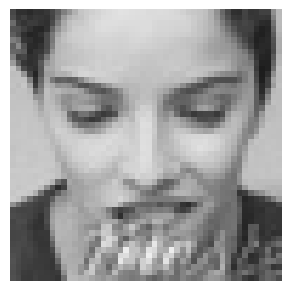

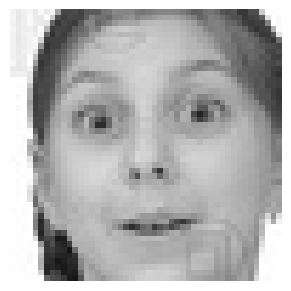

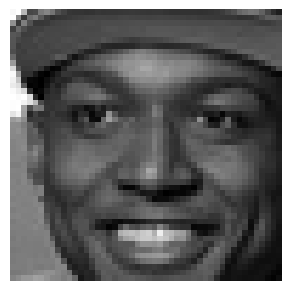

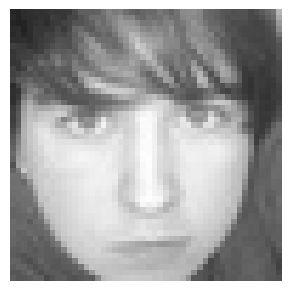

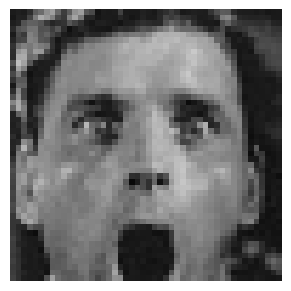

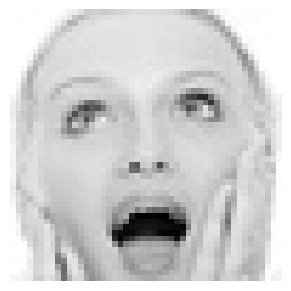

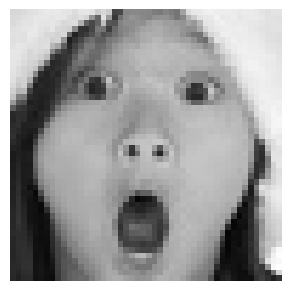

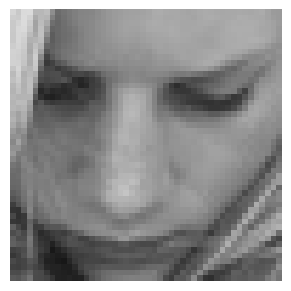

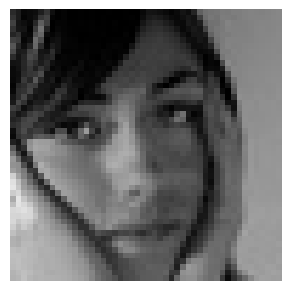

In [5]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [8]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_train.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [10]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Conv2D(64,(3,3), activation='relu')(inputs)
    conv_2 = Conv2D(128,(5,5), activation='relu')(conv_1)
    conv_3 = Conv2D(512,(3,3), activation='relu')(conv_2)
    conv_4 = Conv2D(512,(3,3), activation='relu')(conv_3)

    flatten = Flatten()(conv_4)

    codedense_1 = Dense(256,activation='relu')(flatten)
    codedense_2 = Dense(512, activation='relu')(codedense_1)

    output  = Dense(7, activation="softmax")(codedense_2)
    model  =  Model(inputs=[inputs],outputs = [output])

    opt = Adam(learning_rate=0.0005)

    model.compile(loss='categorical_crossentropy', optimizer = opt, metrics =["accuracy"])

    return model



In [11]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 42, 42, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 38, 38, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 739328)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │     189,268,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 192,559,111 (734.55 MB)

 Trainable params: 192,559,111 (734.55 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
reduce_lr  = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0001)
callbacks = [checkpoint, reduce_lr]


In [ ]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15


C:\Users\Lenovo\anaconda3\prem\envs\emotion_detector\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
